In [ ]:
# !pip install opencv-contrib-python==3.4.2.17

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('image', cmap='gray')

In [ ]:
url_0 = "https://www.purusinternational.com/uploads/tx_pxaproductmanager/724__fal-qbank-8640236759344480257_01.jpg"
url = "https://i.stack.imgur.com/iVb2f.jpg"
url_2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Fishing_House_%283592040389%29.jpg/800px-Fishing_House_%283592040389%29.jpg"
!wget -O images/box_2.jpg $url
!wget -O images/fishing_house.jpg $url_2

# Keypoints

* Keypoint là điểm đặc biệt so với các điểm xung quanh và có thể tìm ghép cặp với một điểm tương tự trong ảnh khác

# Corner detection

# Corner harris
<img src=https://slideplayer.com/slide/8568434/26/images/4/Harris+Detector%3A+Basic+Idea.jpg width=500px style="margin: -75px -15px -65px -15px;">

* Thuật toán:
    1. Tìm cửa sổ có sự thay đổi lớn về độ sáng của pixels theo cả 2 hướng X, Y
    2. Tính R cho mỗi cửa sổ tìm được.
$$\begin{array}{c}{R=\operatorname{det} M-k(\operatorname{trace} M)^{2}} \\ {\operatorname{det} M=\lambda_{1} \lambda_{2}} \\ {\operatorname{trace} M=\lambda_{1}+\lambda_{2}}\end{array}$$
    3. Lọc các góc theo cận.

https://en.wikipedia.org/wiki/Harris_Corner_Detector \
https://courses.cs.washington.edu/courses/cse576/06sp/notes/HarrisDetector.pdf \
https://medium.com/pixel-wise/detect-those-corners-aba0f034078b

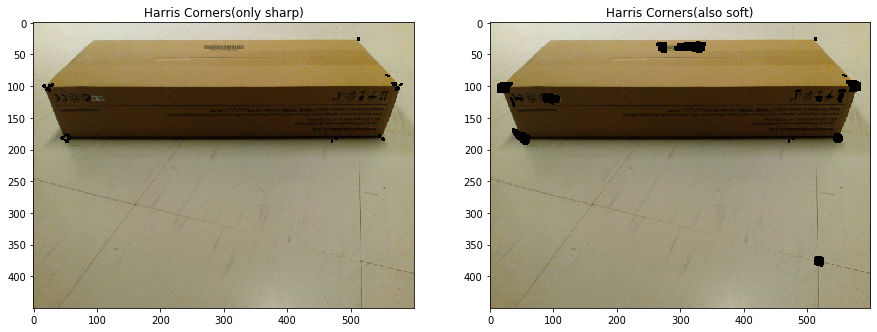

In [180]:
img = cv2.imread('images/box_2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray_2 = cv2.bilateralFilter(gray, 5, 50, 50)
canny = cv2.Canny(gray_2, 100, 300)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(canny,kernel,iterations = 1)

# To detect only sharp corners
dst = cv2.cornerHarris(dilation, blockSize=4, ksize=5, k=0.04)

# Result is dilated for marking the corners
dst = cv2.dilate(dst, None)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Threshold for an optimal value, it may vary depending on the image
img[dst > 0.01*dst.max()] = [0,0,0]

ax[0].imshow(img)
ax[0].set_title('Harris Corners(only sharp)')

# to detect soft corners
dst = cv2.cornerHarris(gray, blockSize=14, ksize=5, k=0.04)
dst = cv2.dilate(dst, None)
img[dst > 0.01*dst.max()] = [0,0,0]

ax[1].imshow(img)
ax[1].set_title('Harris Corners(also soft)')
plt.show()

# Shi-Tomasi Corner Detector

* Shi-Tomasi lấy ý tưởng từ Harris Corner detector nhưng thay đổi cách tính R.
$$R=\min \left(\lambda_{1}, \lambda_{2}\right)$$
* Cách thuật toán được cài đặt cho phép tìm các góc tốt nhất.

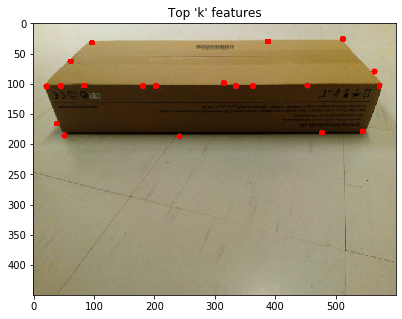

In [179]:
img = cv2.imread('images/box_2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
gray_2 = cv2.bilateralFilter(gray, 5, 50, 50)
canny = cv2.Canny(gray_2, 100, 300)
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(canny,kernel,iterations = 1)

corners = cv2.goodFeaturesToTrack(dilation, maxCorners=20, qualityLevel=0.05, minDistance=20)
corners = np.float32(corners)
for item in corners: 
    x, y = item[0] 
    cv2.circle(img, (x,y), 5, 255, -1)

plt.figure(figsize=(15, 5))
plt.imshow(img)
plt.title("Top 'k' features")
plt.show()

# SIFT (2004)

* Ý tưởng: nhận dạng đặc tính không phụ thuộc vào.
    * Vị trí (độ khó: dễ)
    * Góc quay (độ khó: khó)
    * Kích thước (độ khó: khó)
<br>
* Cách làm:
    1. Xây dựng scale space (không gian kích thước) là thể hiện khác nhau của ảnh để đảm bảo tính bất biến về kích thước.
    2. Ước tính Laplacian of Gaussian (LoG) để tìm key points.
    3. Tìm key points bằng thuật toán ước tính nhanh.
    4. Lọc key points kém (cạnh mờ, ít tương phản). Phương pháp được sử dụng tương tự Harris Corner.
    5. Ước tính góc quay của features.
    6. Tạo SIFT features.

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/ \
http://www.cse.psu.edu/~rtc12/CSE486/lecture31.pdf

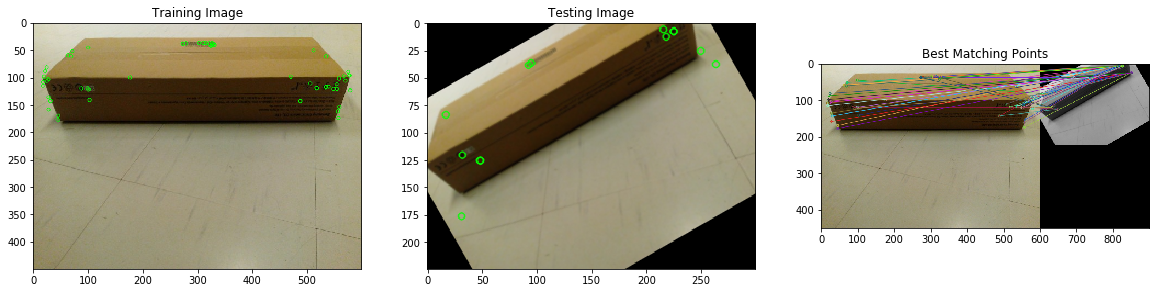

In [246]:
# Load the image
image1 = cv2.imread('./images/box_2.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
num_rows, num_cols = test_image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# SIFT
sift = cv2.xfeatures2d.SIFT_create()
train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)
cv2.drawKeypoints(training_image, train_keypoints, training_image, color=(0,255,0))
cv2.drawKeypoints(test_image, test_keypoints, test_image, color=(0,255,0))

# Perform the matching between the SIFT descriptors of the training image and the test image
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)
matches = bf.match(train_descriptor, test_descriptor)
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)
# Display traning image and testing image
fx, plots = plt.subplots(1, 3, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)
plots[1].set_title("Testing Image")
plots[1].imshow(test_image)
plots[2].set_title('Best Matching Points')
plots[2].imshow(result)
plt.show()

# SURF - Speeded Up Robust Features (2009)

* Là thuật toán nhanh tìm các đặc tính, thể hiện giống nhau giữa các ảnh.
* Cách làm:
    1. Tìm các keypoints có khả năng tìm thấy ở các ảnh khác cao (góc, cụm), ưu tiên các keypoints không phụ thuộc vào kích thước và góc quay.
    2. Tìm góc quay phù cho các ảnh với mỗi keypoint.
    3. Tính thông tin khu vực xung quanh keypoint.

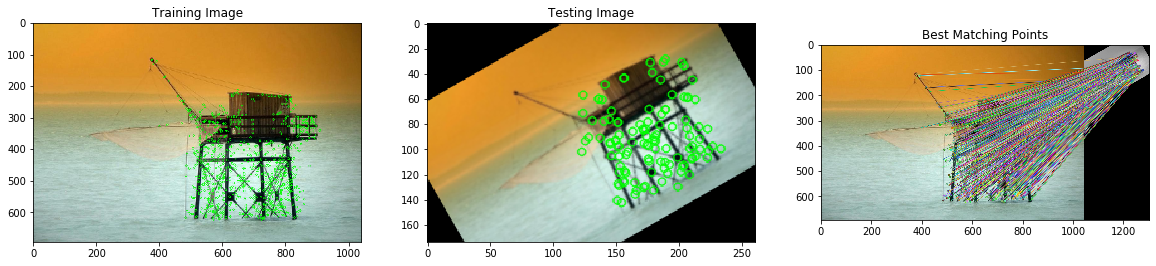

In [233]:
# Load the image
image1 = cv2.imread('./images/fishing_house.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# SUFT
surf = cv2.xfeatures2d.SURF_create(800)
train_keypoints, train_descriptor = surf.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = surf.detectAndCompute(test_gray, None)
cv2.drawKeypoints(training_image, train_keypoints, training_image, color=(0,255,0))
cv2.drawKeypoints(test_image, test_keypoints, test_image, color=(0,255,0))

# Perform the matching between the SURF descriptors of the training image and the test image
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)
matches = bf.match(train_descriptor, test_descriptor)
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display
fx, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title("Training Image")
plots[0].imshow(training_image)
plots[1].set_title("Testing Image")
plots[1].imshow(test_image)
plots[2].imshow(result)
plots[2].set_title('Best Matching Points')
plt.show()

# FAST

* FAST là một thuật toán nhận dạng góc dùng để tìm keypoints cho đeo bám và ánh xạ vật thể.
* Thuật toán tính toán nhanh nên có thể áp dụng với các chương trình thời gian thực.
* So sánh:
<br>$\begin{array}{|l|l|}\hline \text { Detector } & {\mathbf{A}} \\ \hline \text { FAST-ER } & {1313.6} \\ \hline \text { FAST-9 } & {1304.57} \\ \hline \text { DOG } & {1275.57} \\ \hline \text { Shi \& Tomasi } & {1219.08} \\ \hline \text { Harris } & {1195.2} \\ \hline \text { Harris-Laplace } & {1153.13} \\ \hline \text { HaST-12 } & {1121.53} \\ \hline \text { SUSAN } & {1116.79} \\ \hline \text { Random } & {271.73} \\ \hline\end{array}$


https://medium.com/software-incubator/introduction-to-fast-features-from-accelerated-segment-test-4ed33dde6d65

Number of keypoints with non max suppression: 459
Total Keypoints without nonmaxSuppression: 1237


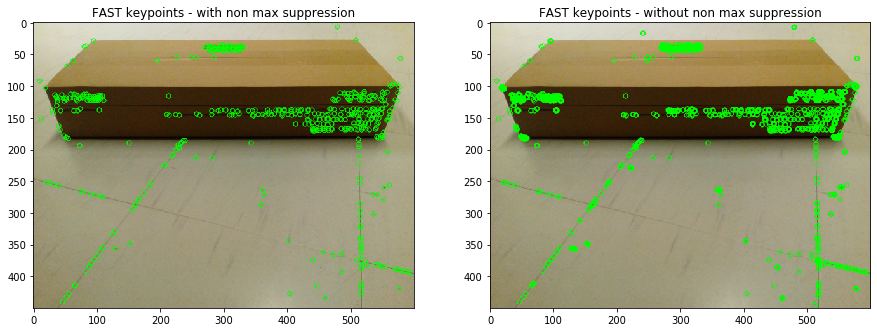

In [196]:
input_image = cv2.imread('images/box_2.jpg')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
fast = cv2.FastFeatureDetector_create()

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
# Detect keypoints
keypoints = fast.detect(gray_image, None)
print("Number of keypoints with non max suppression:", len(keypoints))

# Draw keypoints on top of the input image
img_keypoints_with_nonmax=input_image.copy()
cv2.drawKeypoints(input_image, keypoints, img_keypoints_with_nonmax, 
                  color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax[0].imshow(img_keypoints_with_nonmax)
ax[0].set_title('FAST keypoints - with non max suppression')

# Disable nonmaxSuppression
fast.setNonmaxSuppression(False)

# Detect keypoints again
keypoints = fast.detect(gray_image, None)
print("Total Keypoints without nonmaxSuppression:", len(keypoints))

# Draw keypoints on top of the input image
img_keypoints_without_nonmax=input_image.copy()
cv2.drawKeypoints(input_image, keypoints, img_keypoints_without_nonmax,
                  color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax[1].imshow(img_keypoints_without_nonmax)
ax[1].set_title('FAST keypoints - without non max suppression')
plt.show()

# BRIEF

* FAST tìm được các keypoints nhưng không trích xuất các đặc tính (feature description) của keypoints đó.
* BRIEF là một keypoints descriptor có tốc độ nhanh.
* Cách làm:
    1. Lấy khu vực xung quanh pixel (patch)
        <br><img src="https://miro.medium.com/max/1488/1*lZ1sloEeHwZ3tXw4InCZJw.png" width="400px">
    2. Thể hiện patch dưới dạng vector nhị phân:
        <br><img src="https://miro.medium.com/proxy/1*XWpgdt4Z4xeT-g8hn5JLsA.png" width="400px">

https://medium.com/software-incubator/introduction-to-brief-binary-robust-independent-elementary-features-436f4a31a0e6

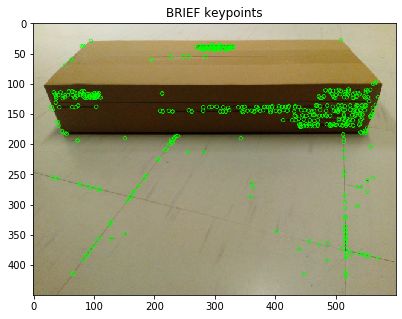

In [223]:
input_image = cv2.imread('images/box_2.jpg')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# find the keypoints with STAR
keypoints = fast.detect(gray_image, None)

# compute the descriptors with BRIEF
keypoints, descriptors = brief.compute(gray_image, keypoints)
cv2.drawKeypoints(input_image, keypoints, input_image, color=(0,255,0))

plt.figure(figsize=(15, 5))
plt.imshow(input_image)
plt.title('BRIEF keypoints')
plt.show()

# ORB - Oriented FAST and Rotated BRIEF (2011)

* Bổ sung đặc tính về góc quay và kích thước cho FAST.
* Kết hợp với feature descriptor BRIEF.
* Phân tích phương sai và tương quan của BRIEF features.
<!-- * A learning method for decorrelating BRIEF features under rotational invariance, leading to better performance in nearest-neighbor applications -->

https://medium.com/software-incubator/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf

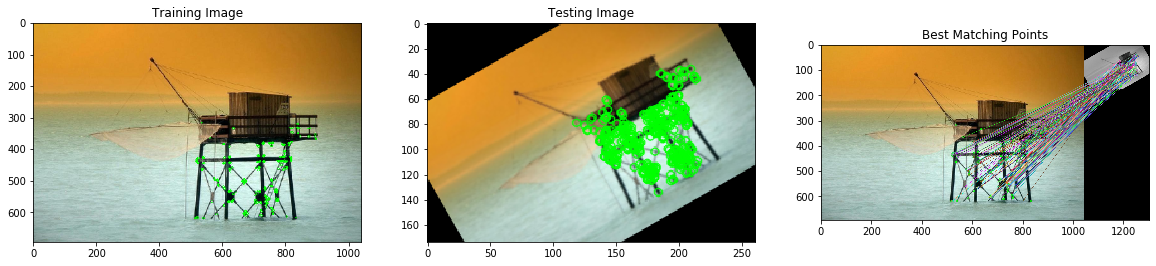

In [234]:
# Load the image
image1 = cv2.imread('./images/fishing_house.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# orb
orb = cv2.ORB_create()
train_keypoints, train_descriptor = orb.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)
cv2.drawKeypoints(training_image, train_keypoints, training_image, color=(0,255,0))
cv2.drawKeypoints(test_image, test_keypoints, test_image, color=(0,255,0))

# Perform the matching between the ORB descriptors of the training image and the test image
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(train_descriptor, test_descriptor)
matches = sorted(matches, key = lambda x : x.distance)
result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display traning image and testing image
fx, plots = plt.subplots(1, 3, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)
plots[1].set_title("Testing Image")
plots[1].imshow(test_image)
plots[2].set_title('Best Matching Points')
plots[2].imshow(result)
plt.show()